In [1]:
import zCurve as z
import csv
import cv2
import os
import numpy as np
import pandas as pd
import glob
import json 
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [2]:
def calculateMortonFromList_with_zCurve(values):
    # Cap floating point numbers to one decimal place and convert to integers
    int_values = [int(round(value, 1) * 10) for value in values]
    value = z.interlace(*int_values, dims=len(int_values))
    return value 

In [3]:
def overlap(cell_cord, yolo_cord): # [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    x_left = max(cell_cord[0], yolo_cord[0])
    x_right = min(cell_cord[2], yolo_cord[2])
    y_top = max(cell_cord[1], yolo_cord[1])
    y_bottom = min(cell_cord[3], yolo_cord[3])

    if x_right < x_left or y_bottom < y_top:
        return 0, 0, 0, 0, 0
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    return overlap_area, x_left, y_top, x_right, y_bottom

In [10]:
zod_path = '../datasets/pie/pie_053/'

In [5]:
config_path = '../config.json'
with open(config_path, 'r') as _f:
    config = json.load(_f)
config['Dataset']['pie']["grid_left_top_coord"]

[[120, 280], [180, 280], [240, 280], [340, 280], [400, 280], [460, 280]]

In [6]:
attention_cells_start_cord = np.array(config['Dataset']['pie']["grid_left_top_coord"])
attention_cell_width = config['General']['roi_width']
attention_cell_height = config['General']['roi_height']
attention_cells_end_cord = [start_piont + np.array([attention_cell_width, attention_cell_height]) for start_piont in attention_cells_start_cord]

In [7]:
cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)
cell_coord_all

array([[120, 280, 180, 400],
       [180, 280, 240, 400],
       [240, 280, 300, 400],
       [340, 280, 400, 400],
       [400, 280, 460, 400],
       [460, 280, 520, 400]])

### Test with one image

In [11]:
bgr = cv2.imread(os.path.join(zod_path, '729.png'))

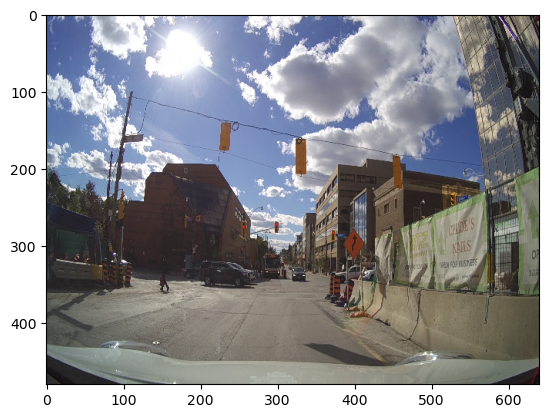

In [12]:
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

In [13]:
yolo = YOLO("yolo11x.pt")  # load an official model
results = yolo.predict(bgr, verbose=False)

In [14]:
for result in results:
    result = result
#print(result)

In [15]:
yolo_start_point = []
yolo_end_point = []
for result in results:
    result = result.boxes.cpu().numpy()
    human_cls_index = np.where(result.cls == 0)
    if result.data.size > 0:
        humans_xyxyc = result.data[human_cls_index].astype(np.int64)
        for i in range(len(humans_xyxyc)):
            yolo_start_point.append([humans_xyxyc[i][0], humans_xyxyc[i][1]])
            yolo_end_point.append([humans_xyxyc[i][2], humans_xyxyc[i][3]])
    else:
        yolo_start_point = None
        yolo_end_point = None


In [16]:
if yolo_start_point is not None and yolo_end_point is not None:
    yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    print(yolo_coord_all)
else: 
    yolo_coord_all = None

[[146 313 160 361]
 [376 344 400 379]]


In [17]:
print(len(yolo_coord_all))
print(cell_coord_all)

2
[[120 280 180 400]
 [180 280 240 400]
 [240 280 300 400]
 [340 280 400 400]
 [400 280 460 400]
 [460 280 520 400]]


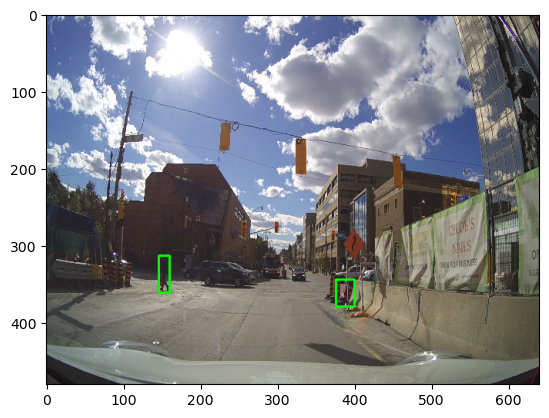

In [18]:
bgr_copy1 = bgr.copy()
#bgr_copy1 = np.zeros_like(bgr)
for i in yolo_coord_all:
    #bgr_copy1[i[1]:i[3], i[0]:i[2]] = bgr[i[1]:i[3], i[0]:i[2]]
    cv2.rectangle(bgr_copy1, [i[0], i[1]], [i[2], i[3]], (0,255,0), 2 )
    #cv2.rectangle(bgr_copy1, [82, 291], [151, 441], (0,255,0), 2 )
    
plt.imshow(cv2.cvtColor(bgr_copy1, cv2.COLOR_BGR2RGB))
#plt.imsave('579_0.png', cv2.cvtColor(bgr_copy1, cv2.COLOR_BGR2RGB))

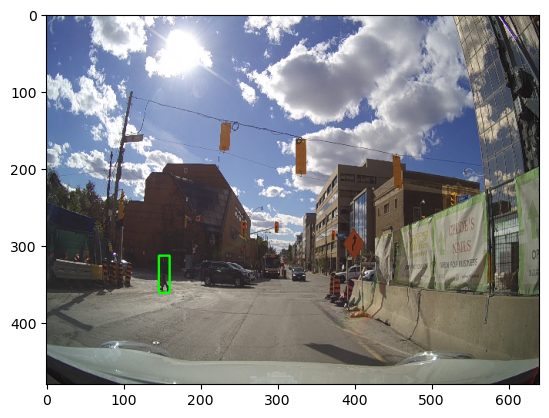

In [20]:
bgr_copy2 = bgr.copy()
#495 281 545 423
cv2.rectangle(bgr_copy2, [146, 313], [160, 361], (0,255,0), 2 )
plt.imshow(cv2.cvtColor(bgr_copy2, cv2.COLOR_BGR2RGB))
#plt.imsave('579_0.png', cv2.cvtColor(bgr_copy1, cv2.COLOR_BGR2RGB))

(480, 640)


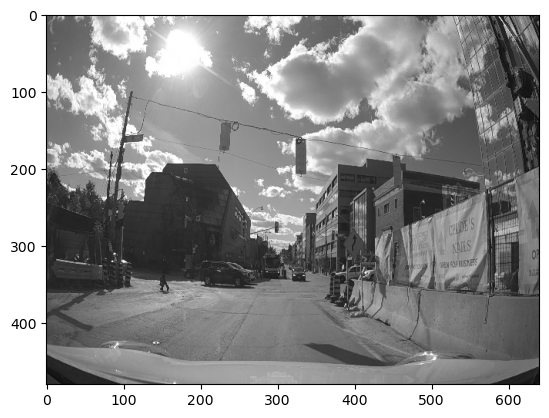

In [21]:
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.imsave('641_gray.png', cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

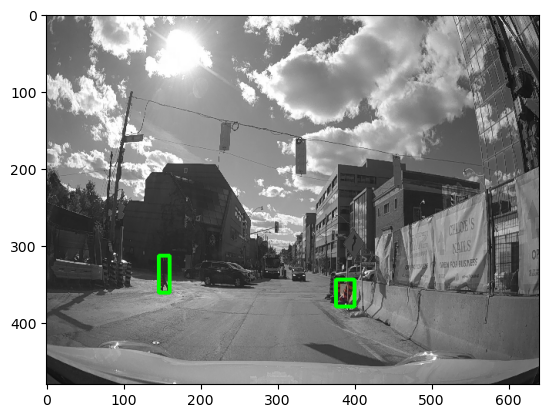

In [22]:
gray_img = cv2.imread('./641_gray.png')
for i in yolo_coord_all:
    gray_img[i[1]:i[3], i[0]:i[2]] = bgr[i[1]:i[3], i[0]:i[2]]
    cv2.rectangle(gray_img, [i[0], i[1]], [i[2], i[3]], (0,255,0), 3 )
plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))
plt.imsave('641_gray_yolo.png', cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))

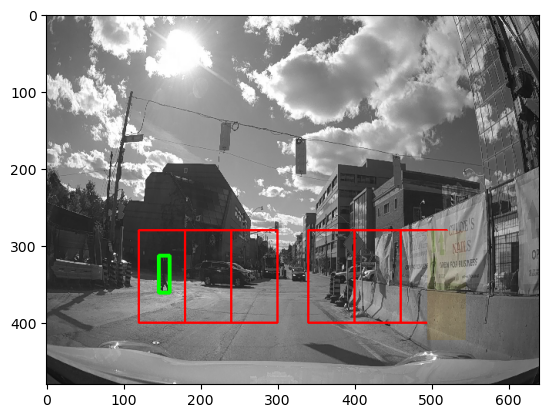

In [24]:
gray_img_1 = cv2.imread('./641_gray.png')
for i in cell_coord_all:
    cv2.rectangle(gray_img_1, [i[0], i[1]], [i[2], i[3]], (0,0,255), 2 )
gray_img_1[281:423, 495:545] = bgr[281:423, 495:545]
cv2.rectangle(gray_img_1, [146, 313], [160, 361], (0,255,0), 3 )
plt.imshow(cv2.cvtColor(gray_img_1, cv2.COLOR_BGR2RGB))
plt.imsave('641_gray_track.png', cv2.cvtColor(gray_img_1, cv2.COLOR_BGR2RGB))

In [41]:
cell_overlap_all = [None] * len(cell_coord_all)
#cell_overlap_all = []
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    cell_yolo_overlap = [None] * len(yolo_coord_all)
    for j in range(len(yolo_coord_all)):
        yolo_coord = yolo_coord_all[j]
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, yolo_coord)
        cell_yolo_overlap[j]= [overlap_area, x_left, y_top, x_right, y_bottom]

    cell_overlap_all[i] = cell_yolo_overlap


In [42]:
len(cell_overlap_all[0])

15

In [43]:
np.sum(np.array(cell_overlap_all[0])[:, 0])

1281

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1564, 460, 332, 483, 400], [154, 460, 323, 462, 400], [1188, 478, 334, 496, 400], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [2975, 495, 281, 520, 400], [0, 0, 0, 0, 0]]


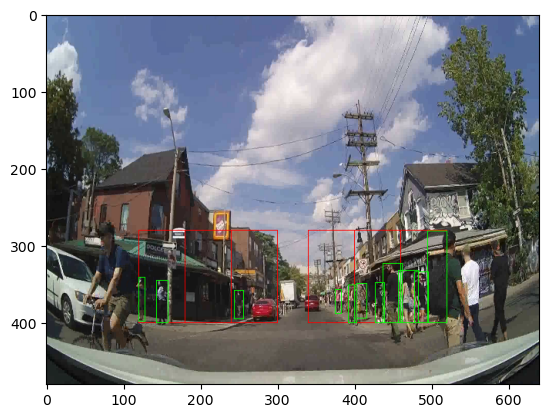

In [44]:
bgr_copy2 = bgr.copy()
for i in cell_coord_all:
    cv2.rectangle(bgr_copy2, i[:2], i[2:], (0,0,255), 1)
print(cell_overlap_all[5])
for j in cell_overlap_all:
    for m in j:
        cv2.rectangle(bgr_copy2, m[1:3], m[3:5], (0,255,0), 1)

plt.imshow(cv2.cvtColor(bgr_copy2, cv2.COLOR_BGR2RGB))

In [45]:
overlap_cum = 0
print(cell_overlap_all[4])
for i in cell_overlap_all[4]:
    if i != [0,0,0,0,0]:
        overlap_cum += i[0]
print(overlap_cum)

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [204, 457, 332, 460, 400], [1771, 437, 323, 460, 400], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [147, 400, 351, 403, 400], [624, 427, 348, 439, 400], [585, 403, 349, 416, 394], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
3331


In [46]:
valid_overlap = [i[1:] for i in cell_overlap_all[4] if i != [0,0,0,0,0]]
valid_overlap

[[457, 332, 460, 400],
 [437, 323, 460, 400],
 [400, 351, 403, 400],
 [427, 348, 439, 400],
 [403, 349, 416, 394]]

# Now try the Binary Method

In [48]:
valid_overlap # exclude the [0,0,0,0] from the list. 

[[457, 332, 460, 400],
 [437, 323, 460, 400],
 [400, 351, 403, 400],
 [427, 348, 439, 400],
 [403, 349, 416, 394]]

In [49]:
valid_overlap = np.array(valid_overlap)

In [50]:
max_x = np.max(valid_overlap[:, [0,2]].reshape(-1))
max_y = np.max(valid_overlap[:, [1,3]].reshape(-1))

In [51]:
print(max_x)
print(max_y)

460
400


In [52]:
empty_img = np.zeros((bgr.shape[0], bgr.shape[1]), dtype=np.uint8)
empty_img.shape

(480, 640)

In [53]:
for i in valid_overlap:
    empty_img[i[1]:i[3], i[0]:i[2]] = 1 # [ymin:ymax,xmin:xmax]

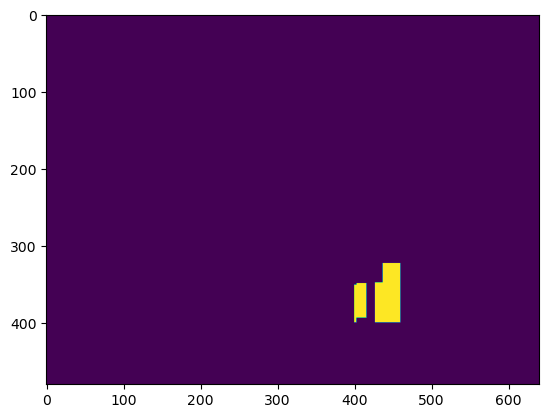

In [54]:
plt.imshow(empty_img)

In [55]:
np.count_nonzero(empty_img == 1)

3023

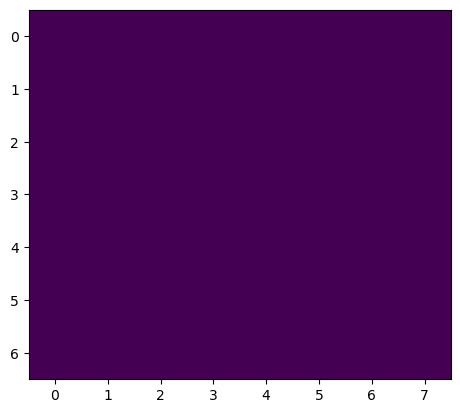

In [56]:
empty_image = np.zeros((7, 8), dtype=np.uint8)
plt.imshow(empty_image)

In [57]:
list_1 = [[2,1,7,6],
          [6,2,8,4],
          [4,0,6,7],
          [1,3,8,5]]

In [58]:
for i in list_1:
    empty_image[i[1]:i[3], i[0]:i[2]] = 1 # [ymin:ymax,xmin:xmax]

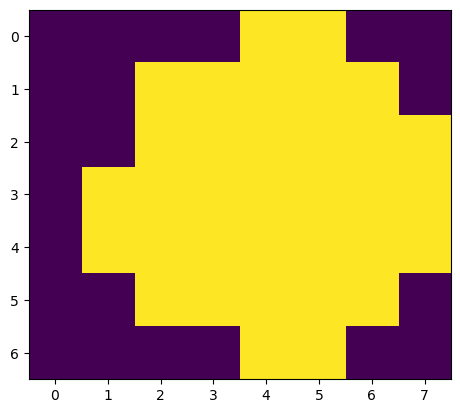

In [59]:
plt.imshow(empty_image)

In [60]:
np.count_nonzero(empty_image == 1)

34

## Try use yolo tracking to filter the bounding box

In [37]:
track_model = YOLO('yolo11x.pt')

In [38]:
for rgb_frame in sorted(glob.glob(os.path.join(zod_path, '*.png'))):
    result = track_model.track(rgb_frame, persist=True, verbose=False)[0]
    result = result.boxes.cpu().numpy()
    human_cls_index = np.where(result.cls == 0)
    if result.data[human_cls_index].size > 0:
        human_cycyc = result.data[human_cls_index].astype(np.uint64)
        human_track_id = result.id[human_cls_index].astype(np.uint64)
    

    #cv2.imshow(annot)
    #print(result)

In [27]:
result.data[human_cls_index].astype(np.uint64)

array([[143, 311, 155, 360, 233,   0,   0],
       [376, 343, 400, 379, 178,   0,   0]], dtype=uint64)

In [28]:
result.xywh[human_cls_index].astype(np.uint16)

array([[149, 336,  11,  49],
       [388, 361,  23,  36]], dtype=uint16)

In [29]:
result.id[human_cls_index].astype(np.uint16)

array([233, 178], dtype=uint16)

In [30]:
result.xyxy

array([[     296.53,      268.92,      302.33,      284.15],
       [     323.69,       161.3,      338.64,      209.61],
       [     225.25,      141.23,      239.97,      177.84],
       [     525.07,      231.03,      533.45,      249.27],
       [     449.91,      182.53,      463.45,      228.42],
       [     370.51,      280.69,      375.54,      294.97],
       [     253.96,      268.26,      260.77,      290.28],
       [     1.1189,      422.73,      637.52,      479.68],
       [     93.038,      243.95,      103.04,      267.57],
       [     219.35,      320.97,      290.87,      355.49],
       [     318.92,      328.37,      337.28,      346.77],
       [     352.48,      325.91,      407.65,      349.38],
       [     143.27,      311.72,      155.04,      360.88],
       [     282.16,      310.91,      305.41,      343.51],
       [     376.93,      343.02,      400.43,      379.33],
       [     160.12,      322.07,      212.13,      344.36],
       [     84.734,    

In [31]:
print(human_cycyc)
print(human_track_id)

[[143 311 155 360 233   0   0]
 [376 343 400 379 178   0   0]]
[233 178]


In [32]:
result = track_model.track(os.path.join(zod_path, '521.png'), persist=True)[0]
result = result.boxes.cpu().numpy()
human_cls_index = np.where(result.cls == 0)
if result.data[human_cls_index].size > 0:
    human_cycyc = result.data[human_cls_index].astype(np.uint64)
    human_track_id = result.id[human_cls_index].astype(np.uint8)

In [33]:
print(human_cycyc)
print(human_track_id)

[[378 343 400 376 178   0   0]]
[178]


In [308]:
a = '/home/autolab/workspace/MMF-DET/ipython/../datasets/pie/output350/521.png'
a.split('/')[-1]

'521.png'

In [214]:
from collections import defaultdict

In [40]:
pie_path = '../datasets/pie/pie_053/'
track_model = YOLO('yolo11x.pt')
d = defaultdict(lambda: [])
df = []
for rgb_frame in sorted(glob.glob(os.path.join(pie_path, '*.png'))):
    bgr = cv2.imread(rgb_frame)
    frame_id = int(rgb_frame.split('/')[-1].split('.')[0])
    result = track_model.track(rgb_frame, persist=True, verbose=False)[0]
    result = result.boxes.cpu().numpy()
    human_cls_index = np.where(result.cls == 0)
    if result.xyxy[human_cls_index].size > 0:
        humans_xyxy = result.xyxy[human_cls_index].astype(np.uint16)
        humans_xywh = result.xywh[human_cls_index].astype(np.uint16)
        humans_track_id = result.id[human_cls_index].astype(np.uint16)

        assert len(humans_track_id) == len(humans_xyxy)
        assert len(humans_xyxy) == len(humans_xywh)
        #print(humans_xyxy)
        #print(humans_track_id)
        # for i in range(len(humans_xyxyc)):
        for xywh, xyxy, track_id in zip(humans_xywh, humans_xyxy, humans_track_id):
            x_lt, y_lt, x_rb, y_rb = xyxy
            x_m, y_m, width, height = xywh
            track = d[track_id]
            track.append((x_lt, y_lt, x_rb, y_rb, x_m, y_m, width, height, frame_id))

            #points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            #cv2.polylines(bgr, [points], isClosed=False, color=(230, 230, 230), thickness=1)
        #df.append({'id': track, 'xyxy': points})

NameError: name 'd' is not defined

In [391]:
full_ped_cross = []
for track_id, xyxyxywhi in d.items():
    center_x_all = [i[4] for i in xyxyxywhi]
    min_center_x = min(center_x_all)
    max_center_x = max(center_x_all)

    if (max_center_x - min_center_x) > 240:
        full_ped_cross.append(xyxyxywhi)
    #break

In [392]:
full_ped_cross

[[(405, 320, 421, 373, 413, 346, 16, 52, 520),
  (405, 320, 422, 372, 414, 346, 16, 52, 521),
  (405, 319, 423, 371, 414, 345, 17, 51, 522),
  (405, 319, 423, 371, 414, 345, 18, 52, 523),
  (405, 319, 424, 371, 414, 345, 19, 52, 524),
  (405, 319, 425, 371, 415, 345, 19, 52, 525),
  (406, 319, 425, 372, 416, 345, 19, 53, 526),
  (406, 319, 426, 374, 416, 346, 20, 55, 527),
  (407, 319, 426, 375, 417, 347, 19, 55, 528),
  (409, 319, 426, 375, 418, 347, 17, 55, 529),
  (410, 319, 425, 374, 418, 347, 15, 54, 530),
  (411, 319, 426, 373, 419, 346, 15, 53, 531),
  (411, 319, 428, 373, 419, 346, 16, 54, 532),
  (412, 319, 428, 374, 420, 346, 15, 55, 533),
  (413, 318, 429, 374, 421, 346, 15, 56, 534),
  (413, 318, 429, 376, 421, 347, 15, 58, 535),
  (414, 318, 430, 375, 422, 346, 15, 57, 536),
  (415, 317, 431, 375, 423, 346, 15, 57, 537),
  (415, 318, 432, 376, 424, 347, 16, 58, 538),
  (415, 317, 433, 378, 424, 347, 17, 60, 539),
  (417, 318, 435, 380, 426, 349, 18, 62, 540),
  (418, 317, 

In [393]:
np.vstack(full_ped_cross)[:,-1]

array([520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,
       582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643,
       644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705,
       706, 707, 708, 709, 710, 711, 712, 713, 71

In [394]:
full_ped_cross = np.vstack(full_ped_cross)

In [395]:
for rgb_frame in sorted(glob.glob(os.path.join(pie_path, '*.png'))):
    #print(rgb_frame)
    frame_id = int(rgb_frame.split('/')[-1].split('.')[0])
    frame_mask = full_ped_cross[:,-1] == frame_id
    
    xyxy = full_ped_cross[frame_mask][:,0:4]
    
    bgr = cv2.imread(rgb_frame)
    bgr_copy = bgr.copy()
    for i in xyxy:
        cv2.rectangle(bgr_copy, (i[0], i[1]), (i[2], i[3]), (0,255,0), 1)

    save_path = rgb_frame.replace('datasets/pie', 'outputs/pie_yolo_track')
    if not os.path.exists(os.path.dirname(save_path)):
         os.makedirs(os.path.dirname(save_path))
    cv2.imwrite(save_path, bgr_copy)
    
    #break

In [374]:
frame_mask

array([ True, False, False, ..., False, False, False])

In [375]:
full_ped_cross[frame_mask]

array([[405, 320, 421, 373, 413, 346,  16,  52, 520],
       [225, 307, 236, 346, 231, 326,  10,  38, 520]])

In [376]:
xyxy

array([[405, 320, 421, 373],
       [225, 307, 236, 346]])

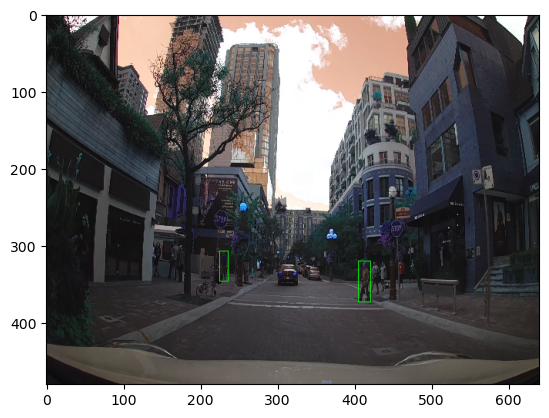

In [381]:
plt.imshow(bgr_copy)

[[471 304 498 424]
 [394 309 419 412]
 [152 283 171 363]
 [375 309 403 408]
 [530 314 543 363]
 [366 313 389 391]
 [241 313 249 341]
 [560 311 569 343]
 [  1 249  27 366]
 [ 27 256  45 308]]


1520
0
224
4615
2002
2592


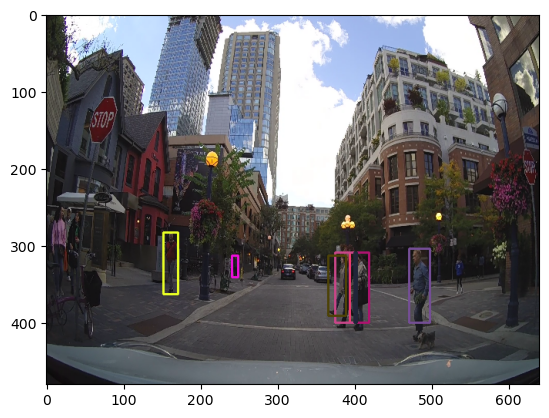

In [38]:
bgr_copy = bgr.copy()
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    
    #cv2.rectangle(bgr_copy, cell_coord[:2], cell_coord[2:], (0,0,255), 2)
    overlap_cum = 0
    #print(i)
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
        
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(bgr_copy, [x_left, y_top], [x_right, y_bottom], color, 2)
        
        overlap_cum += overlap_area
        #print(overlap_area, x_left, y_top, x_right, y_bottom)
    print(overlap_cum)

    #break
plt.imshow(cv2.cvtColor(bgr_copy, cv2.COLOR_BGR2RGB))

In [71]:
input_zcurve = np.zeros(6)
for i in range(len(cell_coord_all)):
    cell_coord = cell_coord_all[i]
    overlap_cum = 0
    for j in yolo_coord_all:
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)    
        overlap_cum += overlap_area

    cell_area = config['attention_grid']['width'] * config['attention_grid']['height']
    if overlap_cum > 0:
        input_zcurve[i] = overlap_cum / cell_area
    
    print(overlap_cum, cell_area, x_left, y_top, x_right, y_bottom)
print(input_zcurve)

3024 7200 136 232 166 304
3996 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
0 7200 0 0 0 0
[       0.42       0.555           0           0           0           0]


In [72]:
morton = calculateMortonFromList_with_zCurve(input_zcurve)
morton

12416

### Combine everything to process all images in a sequence. 

In [36]:
morton_codes = []
sfc_input= []
for rgb_frame in sorted(glob.glob(os.path.join(zod_path, '*.png'))):
    yolo_start_point = []
    yolo_end_point = []
    yolo = YOLO("yolo11x.pt") 
    bgr_resize = cv2.resize(cv2.imread(rgb_frame), (640, 480))
    results = yolo.track(bgr_resize, verbose=False)
    for result in results:
        result = result.boxes.cpu().numpy()
        human_cls_index = np.where(result.cls == 0)
        if result.data[human_cls_index].size > 0:
            humans_xyxyc = result.data[human_cls_index].astype(np.int64)
            for i in range(len(humans_xyxyc)):
                yolo_start_point.append([humans_xyxyc[i][0], humans_xyxyc[i][1]])
                yolo_end_point.append([humans_xyxyc[i][2], humans_xyxyc[i][3]])
        else:
            yolo_start_point = None
            yolo_end_point = None

    if yolo_start_point is not None and yolo_end_point is not None:
        yolo_coord_all = np.concatenate([yolo_start_point, yolo_end_point], axis=1)
    else: 
        yolo_coord_all = None
        
    cell_coord_all = np.concatenate([attention_cells_start_cord, attention_cells_end_cord], axis=1)

    bgr = bgr_resize.copy()

    input_zcurve = np.zeros(6)
    if yolo_coord_all is not None:
        for i in range(len(cell_coord_all)):
            cell_coord = cell_coord_all[i]
            bgr_overlap = cv2.rectangle(bgr, cell_coord[:2], cell_coord[2:], (0,0,255), 2)
            overlap_cum = 0
            for j in yolo_coord_all:
                overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_coord, j)
                color = list(np.random.random(size=3) * 256)
                bgr_overlap = cv2.rectangle(bgr, [x_left, y_top], [x_right, y_bottom], color, 2)
                overlap_cum += overlap_area
            
            cell_area = config['General']['roi_width'] * config['General']['roi_height']
            if overlap_cum > 0:
                input_zcurve[i] = overlap_cum / cell_area
                if input_zcurve[i] >= 1:
                    input_zcurve[i] = 1 
    else:
        for cell_coord in cell_coord_all:
            bgr_overlap = cv2.rectangle(bgr, cell_coord[:2], cell_coord[2:], (0,0,255), 2)
    
    overlap_path = rgb_frame.replace('datasets/', 'outputs/')
    if not os.path.exists(os.path.dirname(overlap_path)):
        os.makedirs(os.path.dirname(overlap_path))
    cv2.imwrite(overlap_path, bgr_overlap)

    sfc_input.append({'frame': rgb_frame, 'cell_0': input_zcurve[0], 'cell_1': input_zcurve[1],
                                             'cell_2': input_zcurve[2], 'cell_3': input_zcurve[3],
                                             'cell_4': input_zcurve[4], 'cell_5': input_zcurve[5]})

    morton_bgr = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_bgr})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/yolo_morton_zod_multi_ped.csv', sep=';', index=False)

sfc_input = pd.DataFrame(sfc_input, columns=['frame', 'cell_0', 'cell_1', 'cell_2',
                                                      'cell_3', 'cell_4', 'cell_5'])
sfc_input.to_csv('../outputs/sfc_input_zod_multi_ped.csv', sep=';', index=False)

### Read the saved csv and plot

In [8]:
morton_codes_yolo_proportion = pd.read_csv('../outputs/yolo_morton_zod_multi_ped.csv', sep=';')
morton_codes_yolo_proportion = morton_codes_yolo_proportion.to_numpy()

In [9]:
mortons_seq = []
for i in range(len(morton_codes_yolo_proportion)):
    frame, morton = morton_codes_yolo_proportion[i]
    mortons_seq.append(int(morton))
print(mortons_seq)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 2, 128, 2, 2, 3, 1, 64, 1, 64, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 65, 4096, 4096, 4160, 4161, 262208, 262145, 262144, 4224, 528449, 12291, 12416, 8259, 8258, 8258, 8640, 8640, 24640, 16513, 16516, 16774, 16774, 24832, 16512, 388, 16772, 390, 386, 132, 10, 518, 33538, 33036, 33036, 33536, 33536, 33540, 33548, 33540, 33036, 33536, 33048, 33040, 540, 1548, 1544, 1544, 1544, 1536, 1552, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1552, 1552, 1552, 1552]


[128, 4096, 4096, 4160, 4161, 4224, 12291, 12416, 8259, 8258, 8258, 8640, 8640, 24640, 16513, 16516, 16774, 16774, 24832, 16512, 388, 16772, 390, 386, 132, 518, 33538, 33036, 33036, 33536, 33536, 33540, 33548, 33540, 33036, 33536, 33048, 33040, 540, 1548, 1544, 1544, 1544, 1536, 1552, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1552, 1552, 1552, 1552]


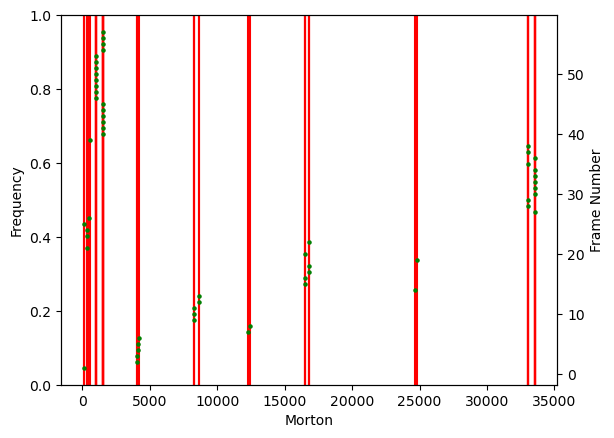

In [12]:
mortons_seq = [i for i in mortons_seq if (i < 50000 and i > 100)]
print(mortons_seq)
fig, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")